#환경설정

In [1]:
pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [2]:
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (19.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 이미지 & 캡션 출력

In [1]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
plt.rc('font', family='NanumBarunGothic') #캡션 한글 출력

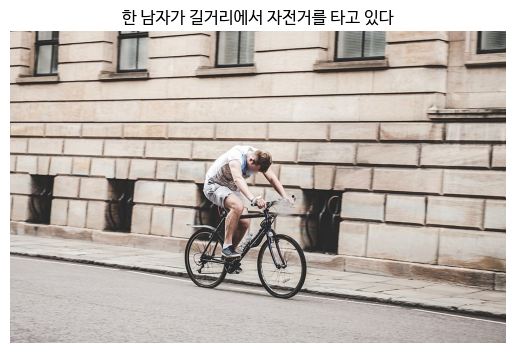

In [55]:
# 폴더 경로 설정
folder_path = '/content/drive/MyDrive/Quiz_image'
folder_path_json = '/content/drive/MyDrive/Quiz_image_json'

# 해당 폴더 내의 모든 파일 목록 가져오기
file_list = os.listdir(folder_path)
file_list_json = os.listdir(folder_path_json)

# 지정된 형식에 맞는 파일만 필터링
filtered_files = [file for file in file_list if file.endswith('.jpg') and file.startswith('image')]

# 랜덤하게 하나의 파일 선택
selected_image_file = random.choice(filtered_files)

# 이미지 파일 경로
image_path = os.path.join(folder_path, selected_image_file)

# 동일한 이름의 JSON 파일 찾기
json_file = selected_image_file.replace('.jpg', '.json')

# JSON 파일 경로
json_path = os.path.join(folder_path_json, json_file)

# JSON 파일 읽기
with open(json_path, 'r') as file:
    data = json.load(file)

# 캡션 추출
caption = data.get('caption', 'No caption available')

# 이미지 로드 및 출력
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # 축 제거
plt.title(caption)  # 캡션을 이미지 위에 출력
plt.show()

# 프롬프트 엔지니어링

In [9]:
## 본인의 openai api 키 입력
OPENAI_API_KEY = 'sk-'

In [10]:
import openai
import os
import time

openai.api_key  = OPENAI_API_KEY

## 파라미터

In [62]:
parameters = {
  "temperature": 0.7,
  "top_p": 0.7,
  "frequency_penalty": 0.5,
  "presence_penalty": 0.55,
  "max_tokens": 2048
}

## 데이터 스키마

In [12]:
quiz_data_schema = {
  "type": "object",
  "properties": {
    "question1": {
      "type": "object",
      "properties": {
        "caption": {
          "type": "string",
          "description": "The caption describing the scenario or context of question 1."
        },
        "key_word": {
          "type": "string",
          "description": "The key word or phrase that is the focus of question 1."
        },
        "options": {
          "type": "object",
          "properties": {
            "correct_answer": {
              "type": "string",
              "description": "The correct answer for the key word of question 1."
            },
            "incorrect_answer": {
              "type": "string",
              "description": "An incorrect answer alternative for the key word of question 1."
            }
          },
          "required": ["correct_answer", "incorrect_answer"]
        }
      },
      "required": ["caption", "key_word", "options"]
    },
    "question2": {
      "type": "object",
      "properties": {
        "caption": {
          "type": "string",
          "description": "The caption describing the scenario or context of question 2."
        },
        "key_word": {
          "type": "string",
          "description": "The key word or phrase that is the focus of question 2."
        },
        "options": {
          "type": "object",
          "properties": {
            "correct_answer": {
              "type": "string",
              "description": "The correct answer for the key word of question 2."
            },
            "incorrect_answer": {
              "type": "string",
              "description": "An incorrect answer alternative for the key word of question 2."
            }
          },
          "required": ["correct_answer", "incorrect_answer"]
        }
      },
      "required": ["caption", "key_word", "options"]
    }
  },
  "required": ["question1", "question2"]
}

## completion API 호출 함수

In [13]:
def get_completion(prompt, model="gpt-3.5-turbo-0613", parameters=None, verbose=False):
    messages = [{"role": "user", "content": prompt}]
    # Implement a function call with JSON output schema
    functions=[{
        "name": "get_new_quiz",
        "description": "Get a new quiz with two options about the given caption. There's only one correct option.",
        "parameters": quiz_data_schema
    }]
    # Define the function which needs to be called when the output has received
    function_call={"name": "get_new_quiz"}

    # parameters가 None이면 기본값을 설정
    if parameters is None:
        parameters = {
            "temperature": 0.7,
            "max_tokens": 150,
            "top_p": 1,
            "frequency_penalty": 0,
            "presence_penalty": 0
        }

    time_start = time.time()
    retry_count = 3

    for i in range(retry_count):
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=messages,
                functions=functions,
                function_call=function_call,
                temperature=parameters.get("temperature"),
                max_tokens=parameters.get("max_tokens"),
                top_p=parameters.get("top_p"),
                frequency_penalty=parameters.get("frequency_penalty"),
                presence_penalty=parameters.get("presence_penalty"),
            )
            #answer = response['choices'][0]['message']['content'].strip()
            answer_json_string = response["choices"][0]["message"]["function_call"]["arguments"]
            tokens = response.usage.total_tokens

            time_end = time.time()

            if verbose:
                print('prompt: %s | tokens: %d | %.1fsec\nanswer: %s' % (prompt, tokens, (time_end - time_start), answer))
            return answer_json_string

        except Exception as error:
            print(f"API Error: {error}")
            print(f"Retrying {i+1} time(s) in 4 seconds...")

            if i+1 == retry_count:
                return prompt, None, None
            time.sleep(4)


## 프롬프트 및 함수 호출 (문제 생성)

In [61]:
prompt = f"""
To support students with lower literacy skills, I'm creating specialized questions.
Each question will focus on substituting a word from a provided sentence.
Both the correct answer and an incorrect alternative will be given.

Procedure for Creating Each Question:
1. Select a sentence.
2. Choose a key word from the sentence.
3. Identify a word that correctly substitutes the key word (Correct Answer).
4. Think of a word that is an incorrect substitute for the key word (Incorrect Answer).

For example:
Question 1:
Caption : "오래된 오토바이 한대가 해변에 주차되어있다.",
Key Word : "주차",
Correct : "정차",
Incorrect : "영차"

Create two questions using different key words from the following caption:
Caption: '''{caption}'''
"""

setquestion = get_completion(prompt, model="gpt-3.5-turbo-0613", parameters=parameters)
print(setquestion)

{
  "question1": {
    "caption": "한 남자가 길거리에서 자전거를 타고 있다",
    "key_word": "길거리",
    "options": {
      "correct_answer": "도로",
      "incorrect_answer": "산책로"
    }
  },
  "question2": {
    "caption": "'한 남자가 길거리에서 자전거를 타고 있다'",
    "key_word": "'타고 있다'",
    options: {
      correct_answer: '운전하다',
      incorrect_answer: '걷다'
}
}
}
